In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.mappings import PT_value_mapping

In [3]:
scale_comp = pd.read_excel('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/Polaris_data.xlsx',sheet_name='ScaleComp')
pt_dat = pd.read_excel('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/Polaris_data.xlsx',sheet_name='PTdat')

In [4]:
pt_dat['year'] = pt_dat.year_to
pt_dat = pt_dat.dropna(subset=['year'])

In [5]:
pt_dat['Scale'] = np.nan
pt_dat['Comp'] = np.nan

row = pt_dat.iloc[0]

for index,row in pt_dat.iterrows():
    scale_comp_pol = scale_comp[scale_comp.PolID == row.polity_new_ID]
    if len(scale_comp_pol) == 0:
        pass
    elif len(scale_comp_pol) == 1:
        pt_dat.loc[index,'Scale'] = scale_comp_pol['Scale'].values[0]
        pt_dat.loc[index,'Comp'] = scale_comp_pol['Comp'].values[0]

    elif len(scale_comp_pol) > 1:
        years = scale_comp_pol['Time'].values
        # find closest year before row.year
        years_before = years[years < row.year]
        if len(years_before) == 0:
            closest_year = years[0]
        else:
            closest_year = years_before[np.argmax(years_before)]
        closest_year_row = scale_comp_pol[scale_comp_pol.Time == closest_year]
        pt_dat.loc[index,'Scale'] = closest_year_row['Scale'].values[0]
        pt_dat.loc[index,'Comp'] = closest_year_row['Comp'].values[0]

In [6]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]

for var in crisis_vars:
    pt_dat[var] = pt_dat[var].map(PT_value_mapping)
    

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_25552/1779505890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_plot.dropna(subset=['Scale','Comp','predecessor_assassination'],inplace=True)


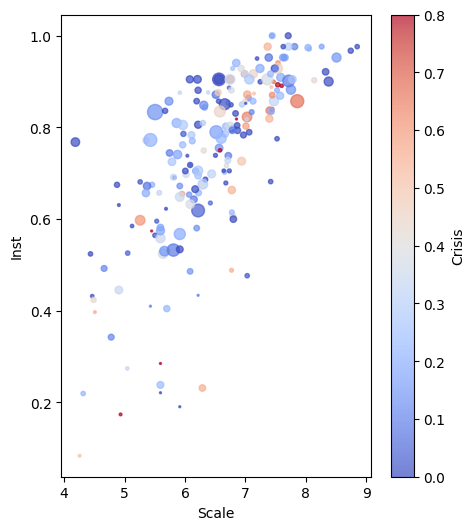

In [7]:
dataset_plot = pt_dat[['polity_new_ID','Scale','Comp','year']+['predecessor_assassination']]
dataset_plot.dropna(subset=['Scale','Comp','predecessor_assassination'],inplace=True)
polity_group = dataset_plot.groupby('polity_new_ID')
fig, ax = plt.subplots(figsize=(5, 6))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale'].mean()
mean_crisis = polity_group['predecessor_assassination'].mean()
num_observations = polity_group.size()

threshold = 0.
if threshold > 0:
    mean_inst_1 = mean_inst_1.loc[mean_crisis > threshold]
    mean_scale_1 = mean_scale_1.loc[mean_crisis > threshold]
    num_observations = num_observations[mean_crisis > threshold]
    mean_crisis = mean_crisis.loc[mean_crisis > threshold]


v_max = mean_crisis.max()*0.8
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 2,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Inst')
plt.xlabel('Scale')
plt.show()

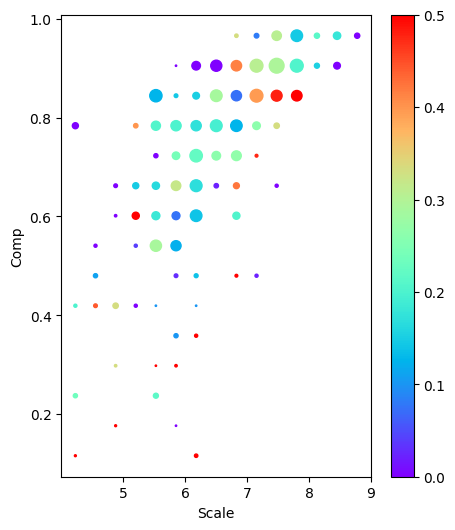

In [8]:
x_cols = ['Scale','Comp']
y_col = 'predecessor_assassination'
Xy = pt_dat[[y_col]+x_cols].dropna()

x = Xy["Scale"].values
y = Xy["Comp"].values
z = Xy["predecessor_assassination"].values

grid_size = 15

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid = df.groupby(['x_bin', 'y_bin'])['z'].mean().unstack()
grid_std = df.groupby(['x_bin', 'y_bin'])['z'].std().unstack()
counts = df.groupby(['x_bin', 'y_bin'])['z'].count().unstack()

fig, ax = plt.subplots(figsize=(5, 6))
x,y = np.meshgrid(x_bins, y_bins)
plt.scatter(x.flatten(), y.flatten(), c=grid.T.values.flatten(), cmap='rainbow', s=counts.T.values.flatten(), vmax = 0.5)
plt.colorbar()
plt.xlabel('Scale')
plt.ylabel('Comp')
# plt.title(crisis_vars)
plt.show()

In [9]:
import statsmodels.api as sm
Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col].apply(int)

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.490186
         Iterations 6
                               Logit Regression Results                              
Dep. Variable:     predecessor_assassination   No. Observations:                 2316
Model:                                 Logit   Df Residuals:                     2313
Method:                                  MLE   Df Model:                            2
Date:                       Wed, 15 Jan 2025   Pseudo R-squ.:                0.006967
Time:                               18:02:49   Log-Likelihood:                -1135.3
converged:                              True   LL-Null:                       -1143.2
Covariance Type:                   nonrobust   LLR p-value:                 0.0003475
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Scale          0.3237      0.083      3.881      0.0

In [20]:
# list sheets of xls file
xl = pd.ExcelFile('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/Polaris_data.xlsx')
print(xl.sheet_names)
# import TSDat1 sheet
tsdat1 = xl.parse('TSDat1')
variable_names = xl.parse('variables')
# create dict out of ShortName and Polaris_var columns
variable_dict = dict(zip(variable_names.ShortName,variable_names.Polaris_var))
variable_dict['PolID'] = 'PolityName'
variable_dict['Time'] = 'Year'
tsdat1.rename(columns=variable_dict,inplace=True)

tsdat1 = tsdat1.rename(columns={'polity_population':'polity-populations', 
                                  'polity_territory':'polity-territories', 
                                  'population_of_the_largest_settlement':'population-of-the-largest-settlements',
                                  'administrative_level':'administrative-levels',
                                  'military_level':'military-levels',
                                  'religious_level':'religious-levels',
                                  'settlement_hierarchy':'settlement-hierarchies',
                                  'professional_priesthood':'professional-priesthoods',
                                  'examination_system':'examination-systems',
                                  'formal_legal-code':'formal-legal-codes',
                                  'merit_promotion':'merit-promotions',
                                  'drinking_water_supply_systems':'drinking-water-supplies',
                                  'generalpostal_service':'general-postal-services',
                                  'script':'scripts',
                                  'phonetic_alphabetic_writing':'phonetic-alphabetic-writings',
                                  'non_phonetic_alphabetic_writing':'non-phonetic-writings',
                                  'calendar':'calendars',
                                  'scientific_literature':'scientific-literatures',
                                  'history':'histories',
                                  'religious-literature':'religious-literatures',
                                  'fiction':'fictions',
                                  'practical-literature':'practical-literatures',
                                  'philosophy':'philosophies',
                                  'paper_currency':'paper-currencies'})

tsdat1['polity-populations']=tsdat1['polity-populations'].apply(lambda x: np.round(10**x) if pd.notna(x) else x)
tsdat1['polity-territories']=tsdat1['polity-territories'].apply(lambda x: np.round(10**x) if pd.notna(x) else x)
tsdat1['population-of-the-largest-settlements']=tsdat1['population-of-the-largest-settlements'].apply(lambda x: np.round(10**x) if pd.notna(x) else x)

['PTdat', 'polities', 'variables', 'TSDat1', 'AggrDat', 'ImpSCDat', 'ScaleComp', 'Religion']


In [21]:
from src.Template import Template
template = Template(categories = ['sc'], file_path= '../datasets/MSP_template_new.csv')

Loaded template from ../datasets/MSP_template_new.csv


In [22]:
df1 = tsdat1
dist = []
lens = []
col = "polity-territories"
for col in df1.columns[4:]:
    for pol in df1.PolityName.unique():
        for year in df1.loc[df1.PolityName == pol].Year.unique():
            value = df1.loc[(df1.PolityName == pol)&(df1.Year == year), col].iloc[0]
            entry = template.template.loc[template.template['PolityName'] == pol, col]
            if len(entry) == 0:
                print(f'polity {pol} missing in template')
                continue
            else:
                entry = entry.iloc[0]
            if pd.isna(entry) and pd.isna(value):
                continue
            elif pd.isna(entry) and pd.notna(value):
                print(f'polity {pol} year {year} value {value} missing in template')
                continue
            elif pd.notna(entry) and pd.isna(value):
                # print(f'polity {pol} year {year} value missing in data')
                continue
            else:
                val_dict = eval(entry)
                
                if (template.is_in_range(val_dict, year, value)):
                    continue
                else:
                    print(f'polity {pol} year {year} value {value} \nnot in range {val_dict["value"]}, expected {template.sample_dict(val_dict, year)}')
                    dist.append((value - template.sample_dict(val_dict, year)))
    lens.append(len(dist))

polity us_antebellum year 1800 value 31443321.0 
not in range [[(3929214, 3929214), (12866020, 12866020), (31443321, 31443321)]], expected 3929214.0
polity at_habsburg_2 year 1800 value 34000000.0 
not in range [[(26000000, 26000000), (30000000, 30000000), (34000000, 34000000), (51390000, 51390000)]], expected 26000000.0
polity at_habsburg_2 year 1900 value 51390000.0 
not in range [[(26000000, 26000000), (30000000, 30000000), (34000000, 34000000), (51390000, 51390000)]], expected 34000000.0
polity gb_british_emp_1 year 1800 value 107500000.0 
not in range [[(5470000, 5470000), (61157433, 61157433), (107500000, 107500000)]], expected 5470000.0
polity gb_british_emp_222222 year 1900 value 531000000.0 
not in range [[(303512568, 303512568), (400000000, 400000000), (458000000, 458000000), (531000000, 531000000)]], expected 400000000.0
polity tr_byzantine_emp_3 year 1100 value 10000000.0 
not in range [[(5000000, 6000000), (10000000, 10000000), (7300000, 7300000)], [(5000000, 6000000), (60

KeyError: 'professional_military_officer'

In [23]:
lens

[30, 63, 96, 100, 103, 103, 107]

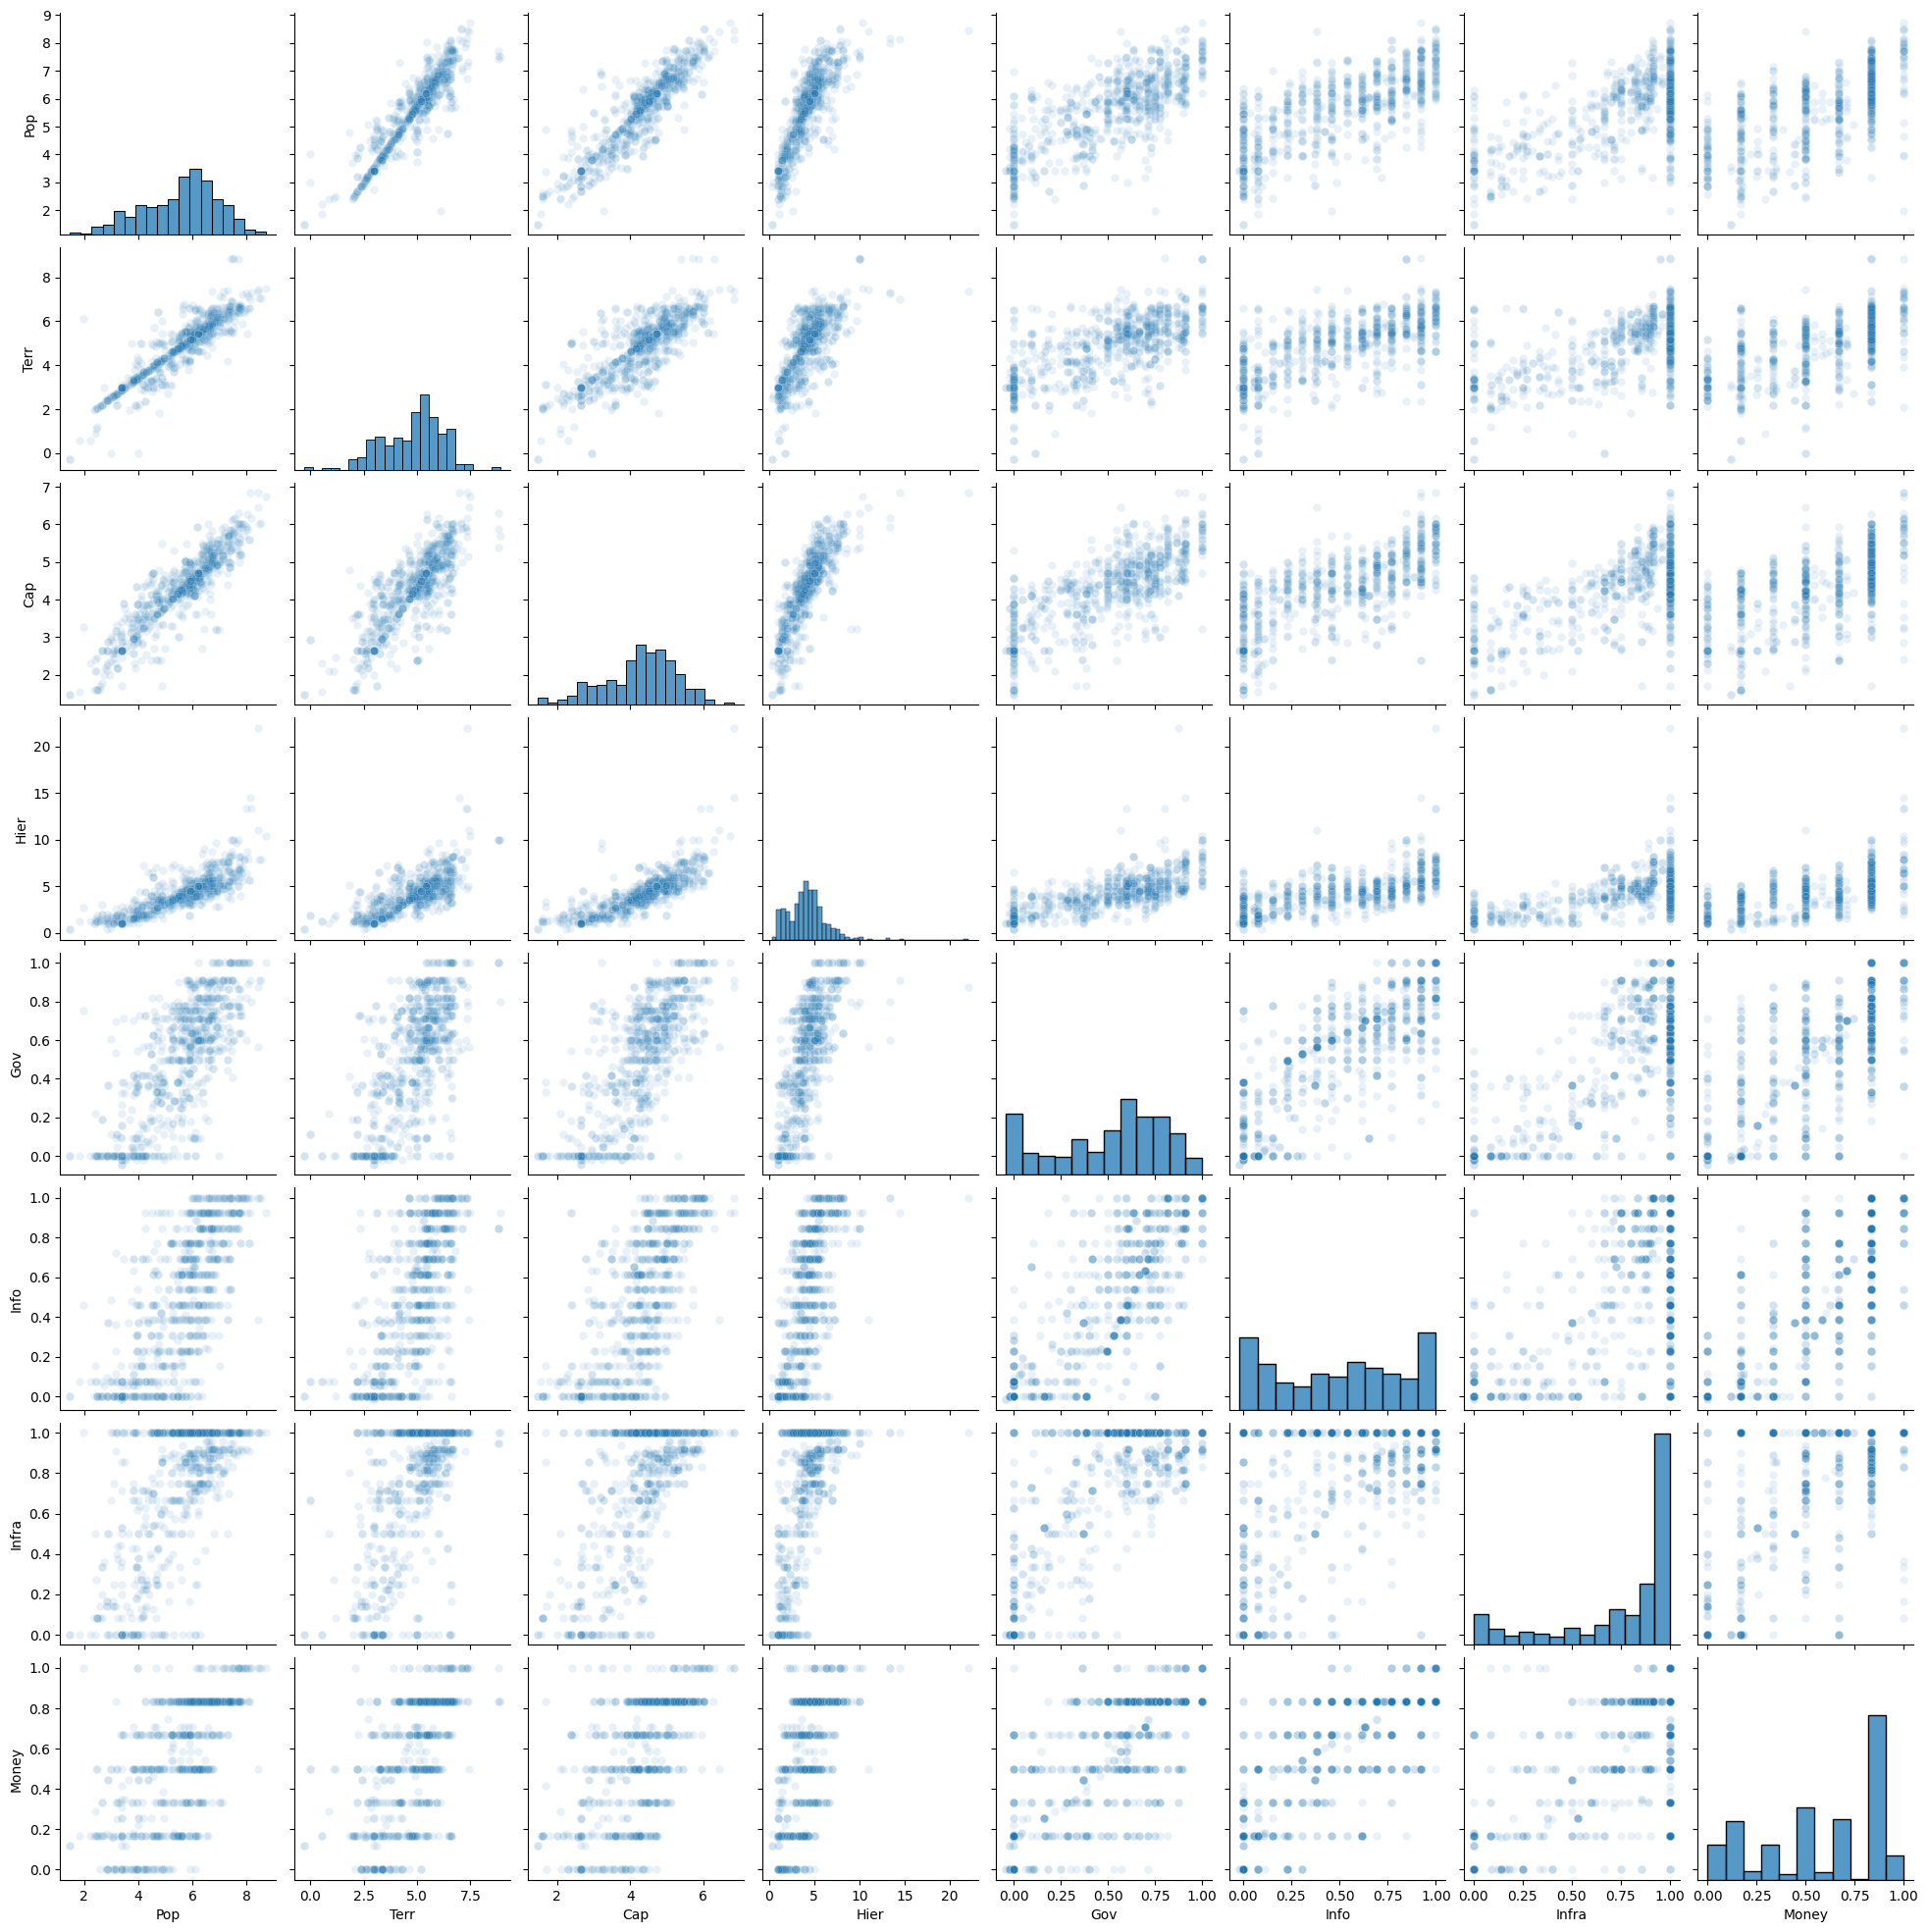

In [14]:
import seaborn as sns
sns.pairplot(imp_dat[['Pop','Terr','Cap', 'Hier', 'Gov', 'Info', 'Infra', 'Money']], plot_kws={'alpha': 0.1})